In [1]:
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import hnn_core
from hnn_core import calcium_model, simulate_dipole, read_params, pick_connection
from hnn_core.network_models import add_erp_drives_to_jones_model
from hnn_core.network_builder import NetworkBuilder
from hnn_core.cell import _get_gaussian_connection
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import utils
from utils import (SingleNeuron_Data, Network_Data, CellType_Dataset_Fast,
                   linear_scale_forward, log_scale_forward, UniformPrior, beta_tuning_param_function)
import multiprocessing
from typing import Dict, Tuple, Optional, List

device = torch.device("cuda:0")
# device = 'cpu'
num_cores = multiprocessing.cpu_count()
torch.backends.cudnn.enabled = True

In [2]:
# Set up prior distribution
prior_dict = {'EI_gscale': {'bounds': (-2, 2), 'rescale_function': log_scale_forward},
              'EE_gscale': {'bounds': (-2, 1), 'rescale_function': log_scale_forward},
              'II_gscale': {'bounds': (-2, 2), 'rescale_function': log_scale_forward},
              'IE_gscale': {'bounds': (-2, 2), 'rescale_function': log_scale_forward},
              'EI_prob': {'bounds': (0, 1), 'rescale_function': linear_scale_forward},
              'EE_prob': {'bounds': (0, 1), 'rescale_function': linear_scale_forward},
              'II_prob': {'bounds': (0, 1), 'rescale_function': linear_scale_forward},
              'IE_prob': {'bounds': (0, 1), 'rescale_function': linear_scale_forward},
              'L2e_distal': {'bounds': (-4, 0), 'rescale_function': log_scale_forward},
              'L2i_distal': {'bounds': (-4, 0), 'rescale_function': log_scale_forward},
              'L5e_distal': {'bounds': (-4, 0), 'rescale_function': log_scale_forward},
              'L5i_distal': {'bounds': (-4, 0), 'rescale_function': log_scale_forward},
              'L2e_proximal': {'bounds': (-4, 0), 'rescale_function': log_scale_forward},
              'L2i_proximal': {'bounds': (-4, 0), 'rescale_function': log_scale_forward},
              'L5e_proximal': {'bounds': (-4, 0), 'rescale_function': log_scale_forward},
              'L5i_proximal': {'bounds': (-4, 0), 'rescale_function': log_scale_forward},
              }

prior = UniformPrior(parameters=list(prior_dict.keys()))
dt = 0.5

In [3]:
# Instiatiate network and collect connectivity data

hnn_core_root = op.dirname(hnn_core.__file__)
params_fname = op.join(hnn_core_root, 'param', 'default.json')
params = read_params(params_fname)
params.update({'N_pyr_x': 7, 'N_pyr_y': 7})

net = calcium_model(params)


# Extract all E-I connection types
E_gids = np.concatenate([net.gid_ranges['L2_pyramidal'], net.gid_ranges['L5_pyramidal']]).tolist()
I_gids = np.concatenate([net.gid_ranges['L2_basket'], net.gid_ranges['L5_basket']]).tolist()

EI_connections = pick_connection(net, src_gids=E_gids, target_gids=I_gids)
EE_connections = pick_connection(net, src_gids=E_gids, target_gids=E_gids)
II_connections = pick_connection(net, src_gids=I_gids, target_gids=I_gids)
IE_connections = pick_connection(net, src_gids=I_gids, target_gids=E_gids)

# Store in dictionary to be added to theta_dict
theta_extra = {'EI_connections': EI_connections, 'EE_connections': EE_connections, 
               'II_connections': II_connections, 'IE_connections': IE_connections,
               'lamtha': 4.0}
theta_extra['sample_idx'] =  0

# Update network parameters
thetai = torch.tensor(np.repeat(0.6, len(prior_dict)))
theta_dict = {param_name: param_dict['rescale_function'](thetai[param_idx].numpy(), param_dict['bounds']) for 
                param_idx, (param_name, param_dict) in enumerate(prior_dict.items())}

theta_dict['theta_extra'] = theta_extra

theta_dict['EI_prob'] = 0.5
theta_dict['EE_prob'] = 0.5
theta_dict['IE_prob'] = 0.5
theta_dict['II_prob'] = 0.5

# theta_dict['IE_gscale'] = 10
# theta_dict['EI_gscale'] = 10
# theta_dict['EE_gscale'] = 10
# theta_dict['II_gscale'] = 10

# theta_dict['L2i_distal'] = 1.0
# theta_dict['L2i_proximal'] = 1.0
# theta_dict['L5i_distal'] = 1.0
# theta_dict['L5i_proximal'] = 1.0


beta_tuning_param_function(net, theta_dict, rate=20)

In [4]:
theta_dict

{'EI_gscale': 2.5118864315095797,
 'EE_gscale': 0.630957344480193,
 'II_gscale': 2.5118864315095797,
 'IE_gscale': 2.5118864315095797,
 'EI_prob': 0.5,
 'EE_prob': 0.5,
 'II_prob': 0.5,
 'IE_prob': 0.5,
 'L2e_distal': 0.025118864315095794,
 'L2i_distal': 0.025118864315095794,
 'L5e_distal': 0.025118864315095794,
 'L5i_distal': 0.025118864315095794,
 'L2e_proximal': 0.025118864315095794,
 'L2i_proximal': 0.025118864315095794,
 'L5e_proximal': 0.025118864315095794,
 'L5i_proximal': 0.025118864315095794,
 'theta_extra': {'EI_connections': [11, 14, 15],
  'EE_connections': [0, 1, 2, 3, 8, 9],
  'II_connections': [12, 13],
  'IE_connections': [4, 5, 6, 7, 10],
  'lamtha': 4.0,
  'sample_idx': 0}}

In [5]:
%%capture
net_drive = net.copy()
net_drive.clear_connectivity()
net_connectivity = net.copy()
_ = simulate_dipole(net_drive, dt=dt, tstop=1000, record_vsec='all', record_isec='all', record_dcell=True)
_ = simulate_dipole(net_connectivity, dt=dt, tstop=1, record_vsec='all', record_isec='all', record_dcell=True)

network_data_drive = Network_Data(net_drive, soma_filter=True)
network_data_connectivity = Network_Data(net_connectivity, soma_filter=True)

In [6]:
dataset_type = 'connected'
dataset_indices = [0]

model_architecture = {'L5_pyramidal': {'hidden_dim': 64, 'n_layers': 5},
                      'L2_pyramidal': {'hidden_dim': 64, 'n_layers': 5},
                      'L5_basket': {'hidden_dim': 8, 'n_layers': 2},
                      'L2_basket': {'hidden_dim': 8, 'n_layers': 2}}

model_dict, dataset_dict = dict(), dict()
for cell_type in net.cell_types:
    cell_type_dataset = torch.utils.data.ConcatDataset(
        [torch.load(f'datasets_{dataset_type}/training_data/{cell_type}_dataset_{idx}.pt') for
         idx in dataset_indices])
    dataset_dict[cell_type] = cell_type_dataset

    _, input_size = cell_type_dataset[0][0].detach().cpu().numpy().shape
    _, output_size = cell_type_dataset[0][1].detach().cpu().numpy().shape

    model_dict[cell_type] = utils.model_celltype_lstm(
        input_size=input_size, output_size=output_size, device=device, **model_architecture[cell_type])
    # model_dict[cell_type] = torch.jit.script(utils.model_celltype_lstm(
    #     input_size=input_size, output_size=output_size, device=device, **model_architecture[cell_type]))
    model_dict[cell_type].load_state_dict(torch.load(f'{dataset_type}_models/{cell_type}_{dataset_type}_model.pt'))
    model_dict[cell_type].to(device)

In [7]:
class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """
    
    scale = 1000.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
spike_fn  = SurrGradSpike.apply


In [11]:
#LSTM/GRU architecture for decoding
class model_network(nn.Module):
    def __init__(self, net, model_dict, dataset_dict, network_data, device='cuda:0', bidirectional=False):
        super(model_network, self).__init__()
        self.net = net
        # self.model_dict = model_dict
        self.L5pyr_model: torch.Module = model_dict['L5_pyramidal']
        self.L2pyr_model: torch.Module = model_dict['L2_pyramidal']
        self.L5basket_model: torch.Module = model_dict['L5_basket']
        self.L2basket_model: torch.Module = model_dict['L2_basket']   
        self.model_dict: torch.ModuleDict[str, torch.Module] = nn.ModuleDict(model_dict)
        self.gid_ranges: Dict[str, np.ndarray] = {cell_type: list(gid_range) for cell_type, gid_range in net.gid_ranges.items()}

        self.kernel_size = model_dict['L5_pyramidal'].kernel_size
        self.dataset_dict = dataset_dict
        self.network_data = network_data
        connectivity_dict = network_data.connectivity_dict.copy()
        self.connectivity_dict = nn.ParameterDict(connectivity_dict)

        EI_dict = dict()
        for cell_type, conn in self.connectivity_dict.items():
            self.connectivity_dict[cell_type] = torch.from_numpy(conn).float().to(device)
            # EI_dict[cell_type] = torch.tensor(0.0).requires_grad_(True).to(device)
            for target_type, _ in self.connectivity_dict.items():
                EI_dict[f'{cell_type}_{target_type}'] = torch.tensor(0.0).requires_grad_(True).to(device)
        self.EI_dict = nn.ParameterDict(EI_dict)

        self.delay_matrix = network_data.delay_matrix

        self.scaler_dict: Dict[str, Dict[str, torch.Tensor]] = self.get_spike_scaler()

        self.soma_idx = 0
        self.threshold_dict = self.get_thresholds()
        self.threshold_dict['L5_basket'] = torch.tensor(10.0).to(device)
        self.threshold_dict['L2_basket'] = torch.tensor(10.0).to(device)

        self.device = device


    @torch.jit.export
    def scale_spikes(self, input_spikes: torch.Tensor, cell_type: str) -> torch.Tensor:
        # input_spikes *= (10 ** self.EI_dict[cell_type])
        input_spikes *= self.scaler_dict[cell_type]['spike_scale']
        input_spikes += self.scaler_dict[cell_type]['spike_min']
        return input_spikes

    def get_thresholds(self):
        threshold_dict = dict()
        for cell_type in self.net.cell_types:
            threshold = (self.net.threshold - self.scaler_dict[cell_type]['vsec_mean'][self.soma_idx]) / \
                self.scaler_dict[cell_type]['vsec_scale'][self.soma_idx]
            threshold_dict[cell_type] = threshold

        return threshold_dict

    def forward(self, L5pyr_spikes: torch.Tensor, L2pyr_spikes: torch.Tensor,
                L5basket_spikes: torch.Tensor, L2basket_spikes: torch.Tensor) -> Tuple[List[torch.Tensor], List[torch.Tensor], List[torch.Tensor], List[torch.Tensor]]:
        input_spikes_dict: Dict[str, torch.Tensor] = {'L5_pyramidal': L5pyr_spikes, 'L2_pyramidal': L2pyr_spikes,
                            'L5_basket': L5basket_spikes, 'L2_basket': L2basket_spikes}

        cell_names = ['L5_pyramidal', 'L2_pyramidal', 'L5_basket', 'L2_basket']

        h0_L5basket = torch.zeros(self.L5basket_model.n_layers, L5basket_spikes.size(0), self.L5basket_model.hidden_dim).to(self.device)
        c0_L5basket = h0_L5basket.clone()

        h0_L2basket = torch.zeros(self.L2basket_model.n_layers, L2basket_spikes.size(0), self.L2basket_model.hidden_dim).to(self.device)
        c0_L2basket = h0_L2basket.clone()

        h0_L5pyr = torch.zeros(self.L5pyr_model.n_layers, L5pyr_spikes.size(0), self.L5pyr_model.hidden_dim).to(self.device)
        c0_L5pyr = h0_L5pyr.clone()

        h0_L2pyr = torch.zeros(self.L2pyr_model.n_layers, L2pyr_spikes.size(0), self.L2pyr_model.hidden_dim).to(self.device)
        c0_L2pyr = h0_L2pyr.clone()
        
        pred_y_dict = {cell_type:
            [torch.zeros((input_spikes_dict[cell_type][:,0,:].size(0),model_dict[cell_type].output_size)).to(self.device),
             torch.zeros((input_spikes_dict[cell_type][:,0,:].size(0), model_dict[cell_type].output_size)).to(self.device)] for
                cell_type in cell_names}
        for time_idx in range(self.kernel_size, input_spikes_dict['L5_basket'].size(1)-1):
 
            batch_x = input_spikes_dict['L2_basket'][:, time_idx-self.L2pyr_model.kernel_size:time_idx, :].clone()
            out_L2_basket = self.scale_spikes(batch_x, 'L2_basket')

            batch_x = input_spikes_dict['L2_pyramidal'][:, time_idx-self.L2pyr_model.kernel_size:time_idx, :].clone()
            out_L2_pyr = self.scale_spikes(batch_x, 'L2_pyramidal')

            batch_x = input_spikes_dict['L5_basket'][:, time_idx-self.L5pyr_model.kernel_size:time_idx, :].clone()
            out_L5_basket = self.scale_spikes(batch_x, 'L5_basket')     

            batch_x = input_spikes_dict['L5_pyramidal'][:, time_idx-self.L5pyr_model.kernel_size:time_idx, :].clone()
            out_L5_pyr = self.scale_spikes(batch_x, 'L5_pyramidal')

            futures : List[torch.jit.Future[Tuple[torch.Tensor, torch.Tensor, torch.Tensor]]] = []
            futures.append(torch.jit.fork(self.L2basket_model, out_L2_basket, h0_L2basket, c0_L2basket))
            futures.append(torch.jit.fork(self.L2pyr_model, out_L2_pyr, h0_L2pyr, c0_L2pyr))
            futures.append(torch.jit.fork(self.L5basket_model, out_L5_basket, h0_L5basket, c0_L5basket ))
            futures.append(torch.jit.fork(self.L5pyr_model, out_L5_pyr, h0_L5pyr, c0_L5pyr))

            # Collect the results from the launched tasks
            results :  List[Tuple[torch.Tensor, torch.Tensor, torch.Tensor]] = []
            for future in futures:
                results.append(torch.jit.wait(future))

            pred_y_dict['L2_basket'].append(results[0][0][:,-1, :])
            pred_y_dict['L2_pyramidal'].append(results[1][0][:,-1, :])
            pred_y_dict['L5_basket'].append(results[2][0][:,-1, :])
            pred_y_dict['L5_pyramidal'].append(results[3][0][:,-1, :])

            h0_L2basket, c0_L2basket = results[0][1], results[0][2]
            h0_L2pyr, c0_L2pyr = results[1][1], results[1][2]
            h0_L5basket, c0_L5basket = results[2][1], results[2][2]
            h0_L5pyr, c0_L5pyr = results[3][1], results[3][2]

            # Detect spikes and update input spikes
            for cell_type in cell_names:
                pred_t1 = pred_y_dict[cell_type][-1][:, self.soma_idx]
                pred_t2 = pred_y_dict[cell_type][-2][:, self.soma_idx]

                spike_greater = spike_fn(pred_t1 - self.threshold_dict[cell_type])
                spike_less = spike_fn(pred_t2 - self.threshold_dict[cell_type])

                spike_mask = spike_greater * (1 - spike_less)
                            
                for target_type in cell_names:
                    input_spikes_dict[target_type][:, time_idx+1, :] += \
                        torch.matmul(self.connectivity_dict[target_type][:, :, self.gid_ranges[cell_type]], \
                            spike_mask * (10 ** self.EI_dict[f'{cell_type}_{target_type}']))

        return (torch.stack(pred_y_dict['L2_basket']), torch.stack(pred_y_dict['L2_pyramidal']),
                torch.stack(pred_y_dict['L5_basket']), torch.stack(pred_y_dict['L5_pyramidal']))
    
    def get_spike_scaler(self):
        scaler_dict = dict()
        for cell_type in net.cell_types:
            scaler_dict[cell_type] = {
                'spike_min': torch.tensor(self.dataset_dict[cell_type].datasets[0].input_spike_scaler.min_).float().to(device),
                'spike_scale': torch.tensor(self.dataset_dict[cell_type].datasets[0].input_spike_scaler.scale_).float().to(device),
                'vsec_mean': torch.tensor(self.dataset_dict[cell_type].datasets[0].vsec_scaler.mean_).float().to(device),
                'vsec_scale': torch.tensor(self.dataset_dict[cell_type].datasets[0].vsec_scaler.scale_).float().to(device),
            }

        return scaler_dict

In [12]:
model_pytorch = model_network(net, model_dict, dataset_dict, network_data_connectivity, device=device, bidirectional=False)
# model = torch.jit.script(model_pytorch).to(device)
model = model_pytorch.to(device)

# Make input spike dict initialized with prox/distal noisy drive
input_spike_dict = dict()
for cell_type in net.cell_types:
    gid_list = net.gid_ranges[cell_type]
    input_spike_dict[cell_type] = torch.from_numpy(
        np.stack([network_data_drive.input_spike_dict[gid].T for gid in gid_list])).float()[:, :1000, :].to(device)


lr = 1
weight_decay = 0
optimizer = torch.optim.Adam(model.EI_dict.parameters(), lr=lr, weight_decay=weight_decay)
# optimizer = torch.optim.Adam(model.connectivity_dict.parameters(), lr=lr, weight_decay=weight_decay)
# optimizer = torch.optim.SGD(model.EI_dict.parameters(), lr=10, momentum=0.0)


In [15]:
print_freq = 1

max_epochs = 1000

EI_dict_list = list()
losses = list()
for epoch in range(max_epochs):
    model.train()
    optimizer.zero_grad()
    # input_spikes = input_spike_dict.clone().to(device).requires_grad_(False)

    pred_y = model(input_spike_dict['L5_pyramidal'].clone(), input_spike_dict['L2_pyramidal'].clone(),
                    input_spike_dict['L5_basket'].clone(), input_spike_dict['L2_basket'].clone())


    dpl = pred_y[1][:,:,-1].mean(axis=1) + pred_y[3][:,:,-1].mean(axis=1)
    out_fft = torch.fft.rfft(dpl).abs() ** 2
    freq = torch.fft.rfftfreq(pred_y[1].size(0), dt / 1e3)


    # power = torch.sum(out_fft[torch.logical_and(freq > 80, freq < 300)])
    power = torch.sum(out_fft[torch.logical_and(freq > 0, freq < 20)])

    relative_power = - power

    relative_power.backward()
    optimizer.step()

    losses.append(relative_power.item())

    #Print Loss Scores
    if (epoch+1)%print_freq == 0:
        print('')
        print('Epoch: {}/{} ...'.format(epoch+1, max_epochs), end=' ')
        print('Relative Power: {:.4f}'.format(-relative_power))

    else:
        print('*', end='')



Epoch: 1/1000 ... Relative Power: 12012016.0000

Epoch: 2/1000 ... Relative Power: 17477196.0000


KeyboardInterrupt: 

In [16]:
print(list(model.EI_dict.items()))

[('L2_basket_L2_basket', Parameter containing:
tensor(-1.9265, device='cuda:0', requires_grad=True)), ('L2_basket_L2_pyramidal', Parameter containing:
tensor(1.8074, device='cuda:0', requires_grad=True)), ('L2_basket_L5_basket', Parameter containing:
tensor(0., device='cuda:0', requires_grad=True)), ('L2_basket_L5_pyramidal', Parameter containing:
tensor(0.3194, device='cuda:0', requires_grad=True)), ('L2_pyramidal_L2_basket', Parameter containing:
tensor(-1.7839, device='cuda:0', requires_grad=True)), ('L2_pyramidal_L2_pyramidal', Parameter containing:
tensor(0.3006, device='cuda:0', requires_grad=True)), ('L2_pyramidal_L5_basket', Parameter containing:
tensor(1.6785, device='cuda:0', requires_grad=True)), ('L2_pyramidal_L5_pyramidal', Parameter containing:
tensor(1.9624, device='cuda:0', requires_grad=True)), ('L5_basket_L2_basket', Parameter containing:
tensor(0., device='cuda:0', requires_grad=True)), ('L5_basket_L2_pyramidal', Parameter containing:
tensor(0., device='cuda:0', requ

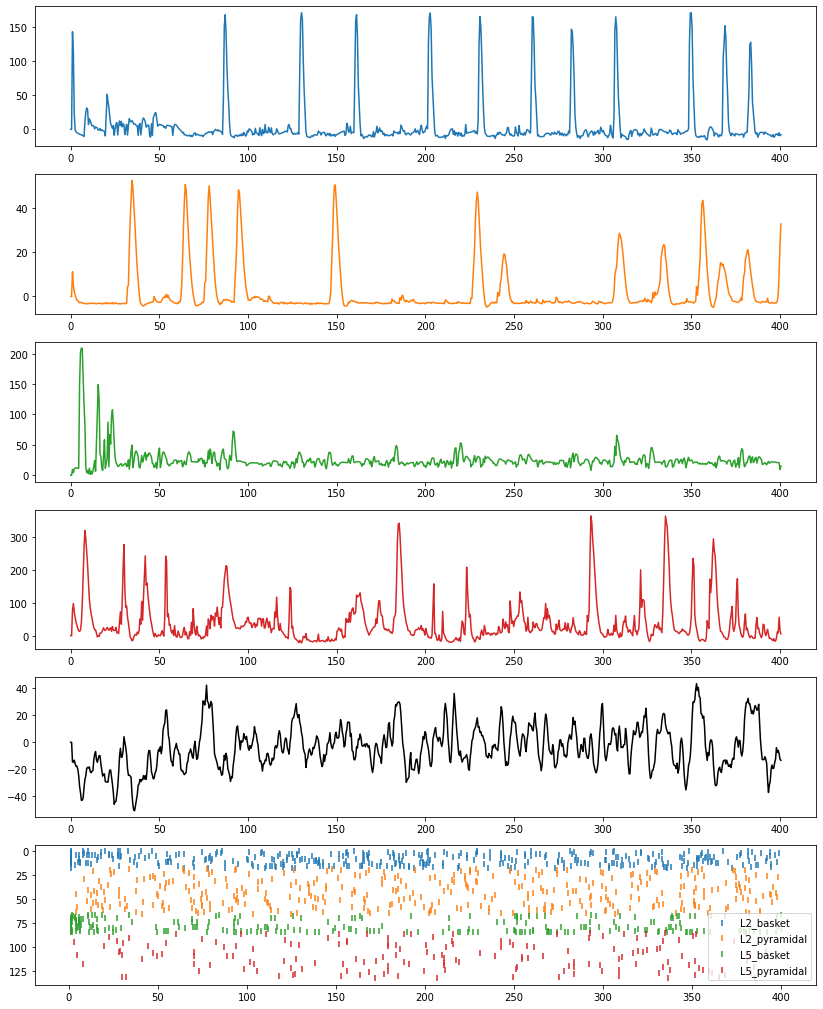

In [17]:
plt.figure(figsize=(14, 18))
for idx, cell_type in enumerate(['L2_basket', 'L2_pyramidal', 'L5_basket', 'L5_pyramidal']):
    out = pred_y[idx][:,:,0].detach().cpu().numpy()

    plt.subplot(6, 1, idx+1)
    pred_trace = out[:,0]
    plt.plot(np.linspace(0, pred_trace.size * 0.5, pred_trace.size), pred_trace, c=f'C{idx}', label=cell_type)

    threshold = model.threshold_dict[cell_type].detach().cpu().numpy()

    cell_spikes = (out > threshold) & (np.roll(out, 1, axis=0) < threshold)
    cell_spike_indices = np.where(cell_spikes > 0)
    offset =  list(net.gid_ranges[cell_type])[0]

    plt.subplot(6, 1, 6)
    plt.scatter(cell_spike_indices[0] * 0.5, cell_spike_indices[1] + offset, c=f'C{idx}', marker='|', label=cell_type)

plt.subplot(6,1,5)
dpl_trace = dpl.detach().cpu().numpy()
plt.plot(np.linspace(0, dpl_trace.size * 0.5, dpl_trace.size), dpl_trace, c='k', label='dpl')

plt.subplot(6,1,6)
plt.gca().invert_yaxis()
plt.legend()
    

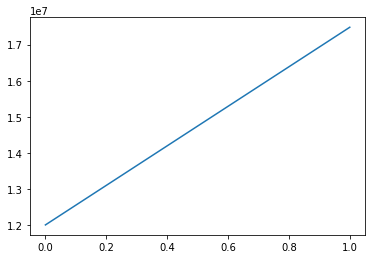

In [18]:
plt.plot(-np.array(losses))
# plt.xlim(0,100)

Text(0, 0.5, 'Power')

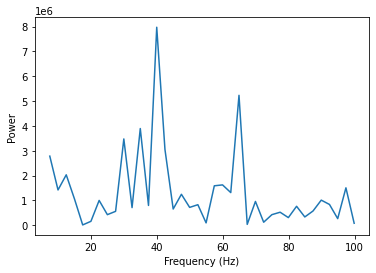

In [19]:
mask = np.logical_and(freq > 5, freq < 100).numpy().astype(bool)
plt.plot(freq.detach().cpu().numpy()[mask], out_fft.detach().cpu().numpy()[mask])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')

In [13]:
# Make input spike dict initialized with prox/distal noisy drive
input_spike_dict = dict()
for cell_type in net.cell_types:
    gid_list = net.gid_ranges[cell_type]
    input_spike_dict[cell_type] = torch.from_numpy(
        np.stack([network_data_drive.input_spike_dict[gid].T for gid in gid_list])).float()[:, :, :].to(device)

with torch.no_grad():
    model.eval()
    pred_y = model(input_spike_dict['L5_pyramidal'].clone(), input_spike_dict['L2_pyramidal'].clone(),
                    input_spike_dict['L5_basket'].clone(), input_spike_dict['L2_basket'].clone())

dpl = pred_y[1][:,:,1].mean(axis=1) + pred_y[3][:,:,1].mean(axis=1)
out_fft = torch.fft.rfft(dpl).abs() ** 2
freq = torch.fft.rfftfreq(pred_y[1].size(0), dt / 1e3)

10.0
36.71259
10.0
357.0925


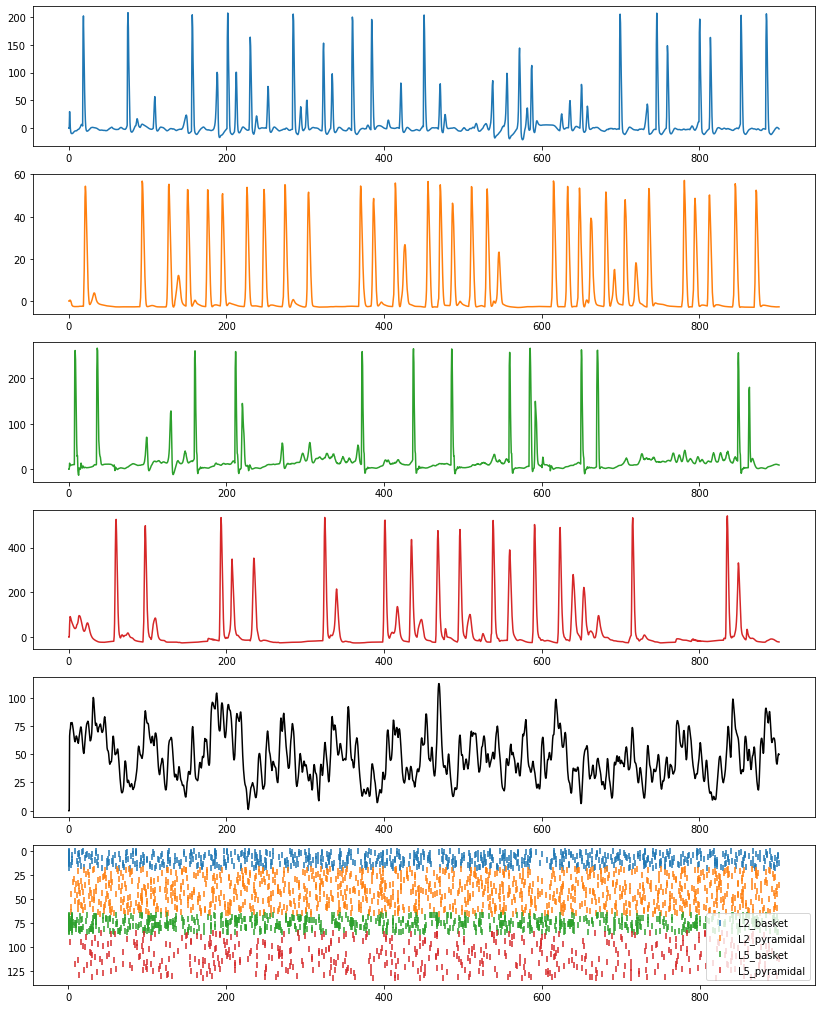

In [14]:
plt.figure(figsize=(14, 18))
for idx, cell_type in enumerate(['L2_basket', 'L2_pyramidal', 'L5_basket', 'L5_pyramidal']):
    out = pred_y[idx][:,:,0].detach().cpu().numpy()

    plt.subplot(6, 1, idx+1)
    pred_trace = out[:,1]
    plt.plot(np.linspace(0, pred_trace.size * 0.5, pred_trace.size), pred_trace, c=f'C{idx}', label=cell_type)

    threshold = model.threshold_dict[cell_type].detach().cpu().numpy()
    print(threshold)

    cell_spikes = (out > threshold) & (np.roll(out, 1, axis=0) < threshold)
    cell_spike_indices = np.where(cell_spikes > 0)
    offset =  list(net.gid_ranges[cell_type])[0]

    plt.subplot(6, 1, 6)
    plt.scatter(cell_spike_indices[0] * 0.5, cell_spike_indices[1] + offset, c=f'C{idx}', marker='|', label=cell_type)

plt.subplot(6,1,5)
dpl_trace = dpl.detach().cpu().numpy()
plt.plot(np.linspace(0, dpl_trace.size * 0.5, dpl_trace.size), dpl_trace, c='k', label='dpl')

plt.subplot(6,1,6)
plt.gca().invert_yaxis()
plt.legend()
    

Text(0, 0.5, 'Power')

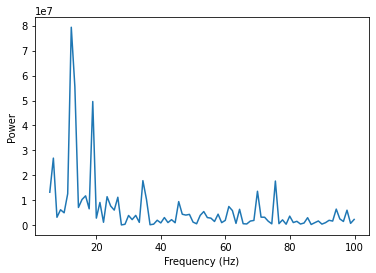

In [15]:
mask = np.logical_and(freq > 5, freq < 100).numpy().astype(bool)
plt.plot(freq.detach().cpu().numpy()[mask], out_fft.detach().cpu().numpy()[mask])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')